## Imports

In [2]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np

import IPython.display as ipd

import librosa
import librosa.display
import pandas as pd

%matplotlib inline

## Audiofiles

Test are yes, no, up, down, left, right, on, off, stop, go. Everything else should be considered either unknown or silence. The folder _background_noise_ contains longer clips of "silence" that you can break up and use as training input.

In [113]:
classes = os.listdir(train_path)

In [5]:
def class_counts(path, classes):
    total_count = 0
    d = {}
    for c in classes:
        i = len(os.listdir(path + c))
        print(c, ':', i)
        d[c] = i
        total_count += i
    print('\n')
    print(f'total counts: {total_count}')
    return d

In [124]:
full_train_path = '../data/train/audio/'
class_dict = class_counts(full_train_path, classes)

tree : 1733
yes : 2377
nine : 2364
no : 2375
on : 2367
stop : 2380
dog : 1746
zero : 2376
seven : 2377
sheila : 1734
go : 2372
cat : 1733
wow : 1745
two : 2373
bird : 1731
one : 2370
up : 2375
house : 1750
left : 2353
six : 2369
off : 2357
four : 2372
five : 2357
right : 2367
eight : 2352
three : 2356
_background_noise_ : 7
marvin : 1746
down : 2359
bed : 1713
happy : 1742


total counts: 64728


In [111]:
# We can see that train:test ratio is about 1:2
# We might consider psuedo-labeling
test_path = '../data/test/audio/'

total_count = 0
i = len(os.listdir(test_path))
total_count += i
print(f'total count {total_count}')

total count 158538


Sample rate is the number of samples of audio carried per second, measured in Hz or kHz (one kHz being 1 000 Hz). For example, 44 100 samples per second can be expressed as either 44 100 Hz, or 44.1 kHz.  

## Inputs

Resources: 
- http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
- https://www.kaggle.com/davids1992/speech-representation-and-data-exploration

Here, we define how to extract and use features for CNNs from raw audio files

### 1.1 WAVE & SPECTOGRAM

In [7]:
# pick a random sound from a given class folder
def random_soundfile(mainpath, cls): return mainpath + cls + '/' + np.random.choice(os.listdir(mainpath + cls))

In [8]:
cls = 'five'
filename = random_soundfile(train_path, cls)
sample_rate, samples = wavfile.read(filename)
ipd.Audio(samples, rate=sample_rate)

In [9]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [10]:
# log spectogram
freqs, times, spectogram = log_specgram(samples, sample_rate)

Text(0.5,0,'Seconds')

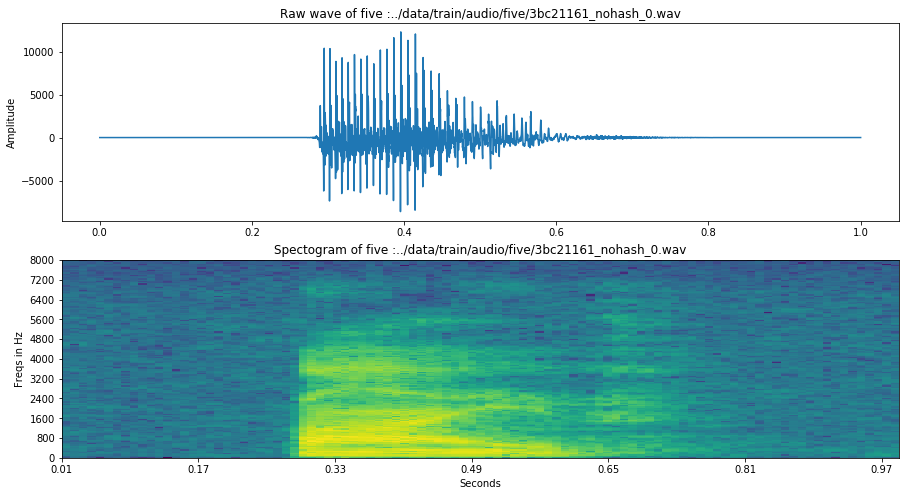

In [11]:
# Plot raw audio signals
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(211)
ax1.set_title(f'Raw wave of {cls} :{filename}')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)
    
# Plot log spectogram time X der
ax2 = fig.add_subplot(212)
ax2.imshow(spectogram.T, aspect= 'auto', origin='lower', 
          extent= [times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title(f'Spectogram of {cls} :{filename}')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

### 1.2 PRE EMPHASIS

 A pre-emphasis filter is useful in several ways: (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, (2) avoid numerical problems during the Fourier transform operation and (3) may also improve the Signal-to-Noise Ratio (SNR).The pre-emphasis filter can be applied to a signal xx using the first order filter in the following equation:

y(t)=x(t)−αx(t−1)

In [20]:
cls = 'five'
filename = random_soundfile(train_path, cls)
sample_rate, samples = wavfile.read(filename)
ipd.Audio(samples, rate=sample_rate)

In [21]:
# like time series 1 time trend differencing
pre_emphasis = 0.97
emphasized_samples = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

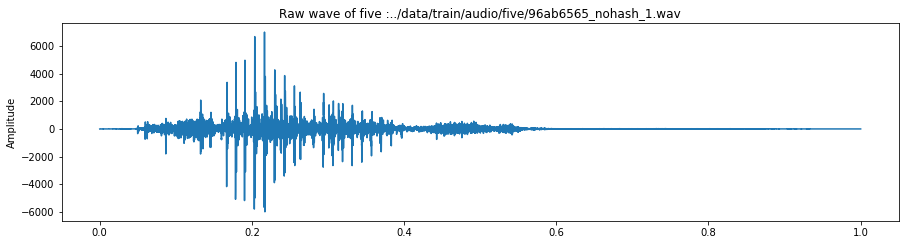

In [22]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(211)
ax1.set_title(f'Raw wave of {cls} :{filename}')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(emphasized_samples), len(emphasized_samples)), emphasized_samples)

In [40]:
# emphasized samples
cls = 'five'
filename = random_soundfile(train_path, cls)
sample_rate, samples = wavfile.read(filename)
ipd.Audio(emphasized_samples, rate=sample_rate)

In [46]:
samples.shape

(16000,)

### 1.3 FRAMING

To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.

In [47]:
frame_size = 0.025
frame_stride = 0.01

In [48]:
samples_length = len(emphasized_samples)
frame_length, frame_step = frame_size*sample_rate, frame_stride*sample_rate
frame_length, frame_step = int(round(frame_length)), int(round(frame_step))
(frame_length, frame_step)

(400, 160)

In [49]:
num_frames = int(np.ceil((samples_length - frame_length) / frame_step))
num_frames

98

In [50]:
pad_sample_length = num_frames*frame_step + frame_length
pad_sample_length

16080

In [51]:
z = np.zeros((pad_sample_length - samples_length))
pad_samples = np.append(emphasized_samples, z)
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
indices.shape

(98, 400)

### 1.4 WINDOW

There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.

In [55]:
frames=pad_samples[indices.astype(np.int32, copy=False)]
frames *= np.hamming(frame_length)

### 1.5 FFT AND POWER SPECTRUM

We can now do an NN-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where NN is typically 256 or 512, NFFT = 512; and then compute the power spectrum (periodogram) using the following equation:

In [54]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

### 1.6 FILTER BANK

In [56]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

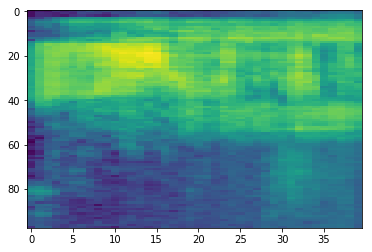

In [57]:
plt.imshow(filter_banks, aspect='auto')

### 1.7 LOG MEL SPECTOGRAM AND MFCC

In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.a

It is your decision which to choose!

In [59]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

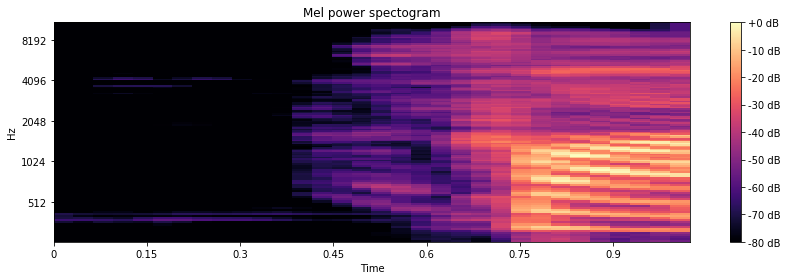

In [60]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

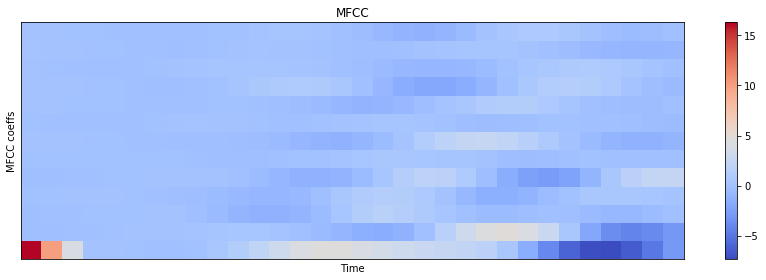

In [61]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

### 1.8 MFCC VS. FILTER BANKS

To this point, the steps to compute filter banks and MFCCs were discussed in terms of their motivations and implementations. It is interesting to note that all steps needed to compute filter banks were motivated by the nature of the speech signal and the human perception of such signals. On the contrary, the extra steps needed to compute MFCCs were motivated by the limitation of some machine learning algorithms. The Discrete Cosine Transform (DCT) was needed to decorrelate filter bank coefficients, a process also referred to as whitening. In particular, MFCCs were very popular when Gaussian Mixture Models - Hidden Markov Models (GMMs-HMMs) were very popular and together, MFCCs and GMMs-HMMs co-evolved to be the standard way of doing Automatic Speech Recognition (ASR)2. With the advent of Deep Learning in speech systems, one might question if MFCCs are still the right choice given that deep neural networks are less susceptible to highly correlated input and therefore the Discrete Cosine Transform (DCT) is no longer a necessary step. It is beneficial to note that Discrete Cosine Transform (DCT) is a linear transformation, and therefore undesirable as it discards some information in speech signals which are highly non-linear.

## Creating Train and Validation Folders

- Create tensorflow train and val sets which is provided by val_list
- We are using these splits since splits provided by tensorflow are gathered by a hash function which carefully takes care of same user samples to be in same bins (only train or only validation)

In [109]:
# create train and val directories under ../data/train
# create class directories under ../data/train/train & ../data/train/val
# get all filepaths under ../data/train/audio
# one by one copy each by checking whether they belong to val_list or not 
# print out results to see class distributions under each folder
val_list = open('../data/train/validation_list.txt').read().split('\n')
train_path = '../data/train/train'
val_path = '../data/train/val'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
for c in classes:
    os.makedirs(train_path + '/' + c, exist_ok=True)
    os.makedirs(val_path + '/' + c, exist_ok=True)
    
main_train_path = '../data/train/audio/'
for r,d,f in os.walk(main_train_path):
    for file in f:
        fpath=os.path.join(r,file)
        cls = fpath.split('/')[4]
        cls_fname = '/'.join(fpath.split('/')[4:])
        #copy files to necessary directories
        #is validation
        if cls_fname in val_list:
            shutil.copy2(fpath, val_path + '/' + cls_fname)
        #is train
        else: shutil.copy2(fpath, train_path + '/' + cls_fname)

In [119]:
# print training split class dist
path = '../data/train/train/'
class_counts(path, classes)

tree : 1567
yes : 2116
nine : 2134
no : 2105
on : 2110
stop : 2134
dog : 1576
zero : 2116
seven : 2114
sheila : 1558
go : 2112
cat : 1565
wow : 1579
two : 2137
bird : 1569
one : 2140
up : 2115
house : 1577
left : 2106
six : 2107
off : 2101
four : 2092
five : 2115
right : 2111
eight : 2109
three : 2108
_background_noise_ : 7
marvin : 1586
down : 2095
bed : 1516
happy : 1553


total counts: 57930


In [122]:
# print validation split class dist
path = '../data/train/val/'
class_counts(path, classes)

tree : 166
yes : 261
nine : 230
no : 270
on : 257
stop : 246
dog : 170
zero : 260
seven : 263
sheila : 176
go : 260
cat : 168
wow : 166
two : 236
bird : 162
one : 230
up : 260
house : 173
left : 247
six : 262
off : 256
four : 280
five : 242
right : 256
eight : 243
three : 248
_background_noise_ : 0
marvin : 160
down : 264
bed : 197
happy : 189


total counts: 6798


## Generating 'silence' and 'unknown'

Predictions will be made on yes, no, up, down, left, right, on, off, stop, go labels and silence and unknown additionally. So we need to generate the silence and unknown data on our own.

In test data there are many unknown samples which some of them are provided in training set like zero...and some not.

** First strategy**

- Put every label other than 'labels' into unknown folder
- split 'background_noise' clips with 80% 20%  without overlapping
- from those splits create train silence and val silence clips (1 min each)


### "Unknown"

In [186]:
labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_background_noise_']

In [176]:
# let's figure out what is meant by silence and unknown in test data
# listening to test clips
rand_file = np.random.choice(os.listdir(test_path))
sample_rate, samples = wavfile.read(test_path + '/' + rand_file)
ipd.Audio(samples, rate=sample_rate)

In [178]:
train_path = '../data/train/train/'
val_path = '../data/train/val/'

In [183]:
#create unknown directory for both train and val
os.makedirs(train_path + 'unknown/', exist_ok=True)
os.makedirs(val_path + 'unknown/', exist_ok=True)

In [197]:
def moveToUnknown(path):
    dirs = os.listdir(path)
    for c in dirs:
        # moving if not in labels list
        if c not in labels:
            fnames = os.listdir(path + c)
            for fname in fnames:
                src = path + c + '/' + fname
                dst = path + 'unknown' + '/' + c + '_' + fname
                shutil.move(src, dst)

In [198]:
moveToUnknown(train_path)
moveToUnknown(val_path)

In [203]:
train_counts = class_counts(train_path, classes + ['unknown']) 
val_counts = class_counts(val_path, classes + ['unknown']) 

tree : 0
yes : 2116
nine : 0
no : 2105
on : 2110
stop : 2134
dog : 0
zero : 0
seven : 0
sheila : 0
go : 2112
cat : 0
wow : 0
two : 0
bird : 0
one : 0
up : 2115
house : 0
left : 2106
six : 0
off : 2101
four : 0
five : 0
right : 2111
eight : 0
three : 0
_background_noise_ : 7
marvin : 0
down : 2095
bed : 0
happy : 0
unknown : 36818


total counts: 57930
tree : 0
yes : 261
nine : 0
no : 270
on : 257
stop : 246
dog : 0
zero : 0
seven : 0
sheila : 0
go : 260
cat : 0
wow : 0
two : 0
bird : 0
one : 0
up : 260
house : 0
left : 247
six : 0
off : 256
four : 0
five : 0
right : 256
eight : 0
three : 0
_background_noise_ : 0
marvin : 0
down : 264
bed : 0
happy : 0
unknown : 4221


total counts: 6798


### "Silence"

- Take each clip background noise 
- Split clip by 80-20
- Create train 1 min clips from 80 part create val 1 min clips from 20 part

In [205]:
train_path = '../data/train/train/'
val_path = '../data/train/val/'

In [206]:
os.makedirs(train_path+'silence', exist_ok=True)
os.makedirs(val_path+'silence', exist_ok=True)

In [207]:
background_path = '../data/train/train/_background_noise_/'

In [288]:
background_fnames = [f for f in os.listdir(background_path) if 'wav' in f]

In [301]:
sample_rate = 16000
n_train = 2200
n_val = 220

for back_fname in background_fnames:
    sample_rate, samples = wavfile.read(background_path + back_fname)
    # split into train and val 80-20
    train_background_arr = samples[:int(len(samples)*0.8)]
    val_background_arr = samples[int(len(samples)*0.8):]
    train_len, val_len = train_background_arr.shape[0], val_background_arr.shape[0]
    
    #create clips for training n_train times
    for i in range(n_train):
        start_idx = np.random.choice(range(train_len - sample_rate))
        seq_idx = range(start_idx, start_idx+sample_rate)
        new_clip = train_background_arr[seq_idx]
        wavfile.write('../data/train/train/silence/' + back_fname + f'_{i}' ,sample_rate, new_clip)
    
    for i in range(n_val):
        start_idx = np.random.choice(range(val_len - sample_rate))
        seq_idx = range(start_idx, start_idx+sample_rate)
        new_clip = val_background_arr[seq_idx]
        wavfile.write('../data/train/val/silence/' + back_fname + f'_{i}' ,sample_rate, new_clip)


/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Get Final Distributions

Finally, we have a train and validation folder containing our data which we will eventually use to train and predict for classes: **yes, no, up, down, left, right, on, off, stop, go, silence and unknown**

In [1]:
train_path = '../data/train/train/'
val_path = '../data/train/val/'

In [3]:
classes = os.listdir(train_path)

In [6]:
train_counts=class_counts(train_path, classes)
print('\n')
val_counts=class_counts(val_path, classes)

tree : 0
yes : 2116
nine : 0
no : 2105
silence : 13200
on : 2110
stop : 2134
dog : 0
zero : 0
seven : 0
sheila : 0
go : 2112
cat : 0
wow : 0
two : 0
bird : 0
one : 0
up : 2115
house : 0
left : 2106
six : 0
off : 2101
unknown : 36818
four : 0
five : 0
right : 2111
eight : 0
three : 0
_background_noise_ : 7
marvin : 0
down : 2095
bed : 0
happy : 0


total counts: 71130


tree : 0
yes : 261
nine : 0
no : 270
silence : 1320
on : 257
stop : 246
dog : 0
zero : 0
seven : 0
sheila : 0
go : 260
cat : 0
wow : 0
two : 0
bird : 0
one : 0
up : 260
house : 0
left : 247
six : 0
off : 256
unknown : 4221
four : 0
five : 0
right : 256
eight : 0
three : 0
_background_noise_ : 0
marvin : 0
down : 264
bed : 0
happy : 0


total counts: 8118
